# Practical info

Date: 17/09/2018
Authors:<br>
- Pau Lopez Ribas<br>
- Adex Gomez<br>
- Zoltan Mark Pinter<br>
- Luka Kovac<br>

### Description

The architecture of the network is formed by a CNN contatenated to a FFNN to classify the pictures.<br>

The CNN consists of 2 block of a convolutional layer, followed by a pooling layer and a activation function.<br>

On the other hand, the FFNN with just one hidden layer to be able to classify between the two categories.<br>

The maximum accuracy we got with this configuration was:

- Accuracy of the network on the 2000 test images: 70.00 %
- Accuracy of cat   : 69.50 %
- Accuracy of dog   : 72.10 %

As you can see is not the best one so we should try to improve it. It However, that was not possible due to time constraints ;)

# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](../static_files/cifar10.png)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
print()

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.train_data[np.where(np.array(trainset.train_labels) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.test_data[np.where(np.array(testset.test_labels) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.train_data = new_train_data
    trainset.train_labels = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.test_data = new_test_data
    testset.test_labels = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified

used classes: ['cat', 'dog']


In [3]:
print("Training data")
print(trainset.train_data.shape)
print(len(trainset.train_labels))
print()

print("Test data")
print(testset.test_data.shape)
print(len(testset.test_labels))
print()

Training data
(10000, 32, 32, 3)
10000

Test data
(2000, 32, 32, 3)
2000



Let us show some of the training images, for fun.



  cat   cat   cat   cat


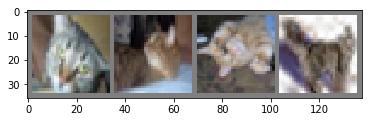

In [4]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

num_filters_conv1 = 16
kernel_size_conv1 = 5 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
num_l1 = 100
padding_conv1 = 0
        
class Net(nn.Module):
    
    #added after num_classes
    def __init__(self, num_classes, input_channels, input_height, input_width, num_zoom = 3):
        super(Net, self).__init__()
        self.num_classes = num_classes
        
        # Your code here!
        self.input_channels = input_channels
        self.input_height = input_height
        self.input_width = input_width
        self.num_zoom = num_zoom
        
        self.conv1 = nn.Conv2d(input_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x
    
    #calculating convolution sizes
    def compute_conv_dim(self, dim_size):
        return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)
    
net = Net(len(used_categories), 3, 32, 32)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Your code here!

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
num_epoch = 3 # Your code here!

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()
        
        # forward + backward + optimize
        # Your code here!
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.676
[1,  2000] loss: 0.642
[2,  1000] loss: 0.605
[2,  2000] loss: 0.600
[3,  1000] loss: 0.563
[3,  2000] loss: 0.569
Finished Training


## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

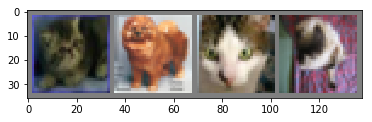

GroundTruth:     cat   dog   cat   cat
Predicted:       dog   dog   dog   cat


In [8]:
images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [9]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.test_data.shape[0], 100 * correct / total))

Accuracy of the network on the 2000 test images: 70.00 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [10]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of cat   : 69.50 %
Accuracy of dog   : 72.10 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images




# Michael Nielsen book exercise of own choice (Ch. 1)

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)


**Answer:**

## DESCRIPTION: Sigmoid neurons simulating perceptrons, part I
Suppose we take all the weights and biases in a network of perceptrons, and multiply them by a positive constant, $c>0$. Show that the behaviour of the network doesn't change.

## RESPONSE:
Perceptrons help us to decide whether to fire the neuron (outputing 1) or not (outputing 0). They use weights and biases to do so.

\begin{equation}
  \text{Output} =\begin{cases}
    0, & \text{if $ \sum_{j} w_{j}x_{j} + b \leq 0 $}.\\
    1, & \text{if $ \sum_{j} w_{j}x_{j} + b > 0 $}.
  \end{cases}
\end{equation}

So what happen if this expression is multiplied by a constant c>0?

\begin{equation}
\sum_{j} c\cdot w_{j}x_{j} + c \cdot b 
\end{equation}

Which is equivalent to,

\begin{equation}
c \cdot \Big(\sum_{j} w_{j}x_{j} + b \Big) 
\end{equation}

Because $c>0$ the result will be exactly the same.  


## DESCRIPTION: Sigmoid neurons simulating perceptrons, part II
Suppose we have the same setup as the last problem - a network of perceptrons. Suppose also that the overall input to the network of perceptrons has been chosen. We won't need the actual input value, we just need the input to have been fixed. Suppose the weights and biases are such that $w⋅x+b≠0$ for the input x to any particular perceptron in the network. Now replace all the perceptrons in the network by sigmoid neurons, and multiply the weights and biases by a positive constant $c>0$. Show that in the limit as $c→∞$ the behaviour of this network of sigmoid neurons is exactly the same as the network of perceptrons. How can this fail when $w⋅x+b=0$ for one of the perceptrons? 

## RESPONSE:
Let's start defining the behaviour of a sigmoid neuron: 

\begin{equation}
\sigma (z) = \frac{1}{1 + \exp \Big(-\sum_{j} w_{j}x_{j} - b \Big)} = \frac{1}{1 + \exp \Big(-z \Big)}
\end{equation}

Meaning that:<br>
if      $z \rightarrow +\infty$ then $\sigma(z) \rightarrow 1$, <br>
else if $z \rightarrow -\infty$ then $\sigma(z) \rightarrow 0$.<br>

![sigmoid.png](attachment:sigmoid.png)

Then, if multiplying $z$ by a constant $c$,

\begin{equation}
c \cdot z = c \cdot \Big(\sum_{j} w_{j}x_{j} + b \Big).
\end{equation}

Then, the sigmoid function will look like, 

\begin{equation}
\sigma(c \cdot z) = \frac{1}{1 + \exp(-c \cdot z)}.
\end{equation}

Therefore,<br>
if $\ \ \ \ \ \ \ c \rightarrow +\infty\ $ then $\ \exp(-c \cdot z) \rightarrow 0\ \ \ $ and $\ \sigma(c \cdot z) = 1$,<br>
else if $\ c \rightarrow -\infty\ $ then $\ exp(-c \cdot z) \rightarrow \infty\ \ $ and $\ \sigma(c \cdot z) = 0$,<br>
else if $\ c \rightarrow \ \ 0\ \ \ $ then $\ \exp(-c \cdot z) \rightarrow 1\ \ \ $ and $\ \sigma(c \cdot z) = \frac{1}{2}$.<br>

As it can be seen, it is a problem if the value of $z \in [-4,4]$, like with the example of $c = 0$.
